# Curso de Classificação: Combinação de Classificadores

# 1 - Testando modelos clássicos

## Vídeo 1.2 - Situação problema

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

In [2]:
treino = pd.read_csv('https://raw.githubusercontent.com/alura-cursos/combina-classificadores/main/dados/train.csv')
teste = pd.read_csv('https://raw.githubusercontent.com/alura-cursos/combina-classificadores/main/dados/test.csv')

In [3]:
treino.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [4]:
treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

In [5]:
treino.isna().sum()

Unnamed: 0                             0
id                                     0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
satisfaction    

In [6]:
def prepara(df):
  df.drop(['Unnamed: 0',	'id'],axis=1,inplace=True)
  df.dropna(inplace=True)
  colunas_categoricas = ["Gender", "Customer Type", "Type of Travel", "Class"]
  df = pd.get_dummies(df, columns=colunas_categoricas)
  X = df.drop('satisfaction', axis=1)
  y = df['satisfaction']
  return X,y

In [7]:
X_treino, y_treino = prepara(treino)
X_teste, y_teste = prepara(teste)

In [8]:
treino.shape

(103594, 23)

In [9]:
teste.shape

(25893, 23)

In [11]:
modelo1 = DecisionTreeClassifier(random_state=42)

validacao = cross_validate(modelo1, X_treino, y_treino, cv=5)

In [12]:
validacao['test_score'].mean()

0.9443500672495754

In [13]:
y_treino.value_counts()

satisfaction
neutral or dissatisfied    58697
satisfied                  44897
Name: count, dtype: int64

In [14]:
modelo1.fit(X_treino,y_treino)

DecisionTreeClassifier(random_state=42)

In [15]:
y_pred = modelo1.predict(X_teste)

In [17]:
accuracy_score(y_teste,y_pred)

0.94612443517553

## Vídeo 1.3 - Pipeline

In [19]:
modelo2 = LogisticRegression(random_state=42)

In [20]:
validacao = cross_validate(modelo2, X_treino, y_treino, cv=5)

/home/rafael/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/rafael/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

In [21]:
validacao['test_score'].mean()

0.8199219877622653

In [23]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Normalização dos dados
    ('model', modelo2)  # Modelo de Regressão Logística
])

In [24]:
validacao = cross_validate(pipeline, X_treino, y_treino, cv=5)

In [25]:
validacao['test_score'].mean()

0.8749541859894492

# 2 - Votação

## Vídeo 2.1 - Votando no melhor resultado

In [27]:
modelo3 = GaussianNB()

In [30]:
nome_modelos = ['Árvores', 'Logística','Naive Bayes']

pipelines = []

for modelo, nome in zip([modelo1,modelo2,modelo3],nome_modelos):

  pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Normalização dos dados
    ('model', modelo)
  ])

  validacao = cross_validate(pipeline, X_treino, y_treino, cv=5)
  pipelines.append(pipeline)

  print(validacao['test_score'].mean())


0.9443983339909126
0.8749541859894492
0.8483406855152964


In [31]:
votacao = VotingClassifier(estimators=[(nome_modelos[0], pipelines[0]),
                                       (nome_modelos[1], pipelines[1]),
                                       (nome_modelos[2], pipelines[2])],
                           voting='hard')

In [32]:
votacao

VotingClassifier(estimators=[('Árvores',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('model',
                                               DecisionTreeClassifier(random_state=42))])),
                             ('Logística',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('model',
                                               LogisticRegression(random_state=42))])),
                             ('Naive Bayes',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('model', GaussianNB())]))])

In [33]:
validacao = cross_validate(votacao, X_treino, y_treino, cv=5)


validacao['test_score'].mean()

0.8917601803912731

In [34]:
validacao['test_score']

array([0.88976302, 0.89135576, 0.88928037, 0.89251412, 0.89588763])

## Vídeo 2.2 - Votação SOFT

In [35]:
votacao = VotingClassifier(estimators=[(nome_modelos[0], pipelines[0]),
                                       (nome_modelos[1], pipelines[1]),
                                       (nome_modelos[2], pipelines[2])],
                           voting='soft')

In [36]:
validacao = cross_validate(votacao, X_treino, y_treino, cv=5)


validacao['test_score'].mean()

0.9007375478071673

In [37]:
votacao.fit(X_treino,y_treino)

VotingClassifier(estimators=[('Árvores',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('model',
                                               DecisionTreeClassifier(random_state=42))])),
                             ('Logística',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('model',
                                               LogisticRegression(random_state=42))])),
                             ('Naive Bayes',
                              Pipeline(steps=[('scaler', StandardScaler()),
                                              ('model', GaussianNB())]))],
                 voting='soft')

In [38]:
y_pred = votacao.predict(X_teste)

In [39]:
accuracy_score(y_teste,y_pred)

0.897230911829452

## Vídeo 2.3 - Tunando a votação

In [40]:
parametros = {
    'voting':['hard','soft'],
    'weights':[(1,1,1),(2,1,1),(1,2,1),(1,1,2)] # peso para os modelos
}

In [42]:
gridsearch = GridSearchCV(votacao,parametros,n_jobs=-1)

In [43]:
gridsearch.fit(X_treino,y_treino)

GridSearchCV(estimator=VotingClassifier(estimators=[('Árvores',
                                                     Pipeline(steps=[('scaler',
                                                                      StandardScaler()),
                                                                     ('model',
                                                                      DecisionTreeClassifier(random_state=42))])),
                                                    ('Logística',
                                                     Pipeline(steps=[('scaler',
                                                                      StandardScaler()),
                                                                     ('model',
                                                                      LogisticRegression(random_state=42))])),
                                                    ('Naive Bayes',
                                                     Pipeline(steps=[('scaler',
                                                                      StandardScaler()),
                                                                     ('model',
                                                                      GaussianNB())]))],
                                        voting='soft'),
             param_grid={'voting': ['hard', 'soft'],
                         'weights': [(1, 1, 1), (2, 1, 1), (1, 2, 1),
                                     (1, 1, 2)]})

In [44]:
gridsearch.best_params_

{'voting': 'soft', 'weights': (2, 1, 1)}

In [45]:
gridsearch.best_score_

0.9443983339909126

In [46]:
y_pred = gridsearch.predict(X_teste)

In [47]:
accuracy_score(y_teste,y_pred)

0.9462402966052601

# 3 - Bagging

## Vídeo 3.1 - BaggingClassifier

In [49]:
bagging_classifier = BaggingClassifier(n_estimators=10, random_state=42)

In [50]:
bagging_classifier.fit(X_treino, y_treino)

BaggingClassifier(random_state=42)

In [51]:
y_pred = bagging_classifier.predict(X_teste)

In [52]:
accuracy_score(y_teste,y_pred)

0.9586760900629514

## Vídeo 3.2 - Validando o Bagging

In [53]:
# Definir os modelos base
modelo_base = pipelines[0]

# Definir os parâmetros para o GridSearchCV
parametros_grid = {
    'n_estimators': [10, 20, 30],
    'max_samples': [0.5, 0.7, 0.9],
    'max_features': [0.5, 0.7, 0.9],
}

In [54]:
# Criar o BaggingClassifier com o GridSearchCV
bagging_grid = GridSearchCV(
    BaggingClassifier(),
    parametros_grid,
    cv=5  # número de folds para a validação cruzada
)


# Treinar e ajustar o modelo
bagging_grid.fit(X_treino, y_treino)

# Obter a melhor combinação de parâmetros encontrada pelo GridSearchCV
melhores_parametros = bagging_grid.best_params_

# Criar o BaggingClassifier com os melhores parâmetros encontrados
bagging_classifier = BaggingClassifier(estimator=modelo_base, **melhores_parametros)

# Treinar o modelo final
bagging_classifier.fit(X_treino, y_treino)

# Fazer previsões
y_pred = bagging_classifier.predict(X_teste)

# Avaliar o desempenho do modelo
accuracy_score(y_teste, y_pred)

0.9626539991503495

## Vídeo 3.3 - ExtraTreesClassifier

In [55]:
parametros_grid = {
    'n_estimators': [10, 20, 30],
    'max_features': [0.5, 0.7, 0.9],

}

In [57]:
extratrees_grid = GridSearchCV(
    ExtraTreesClassifier(),
    parametros_grid,
    cv=5  # número de folds para a validação cruzada
)

In [58]:
# Treinar e ajustar o modelo
extratrees_grid.fit(X_treino, y_treino)

# Obter a melhor combinação de parâmetros encontrada pelo GridSearchCV
melhores_parametros = extratrees_grid.best_params_

# Criar o ExtraTreesClassifier com os melhores parâmetros encontrados
extratrees_classifier = ExtraTreesClassifier(**melhores_parametros)

# Treinar o modelo final
extratrees_classifier.fit(X_treino, y_treino)

# Fazer previsões
y_pred_tree = extratrees_classifier.predict(X_teste)

# Avaliar o desempenho do modelo
accuracy_score(y_teste, y_pred_tree)

0.96392847487738

In [59]:
extratrees_grid.best_score_

0.9627101977005147

# 4 - Boosting

## Vídeo 4.1 - AdaBoost

In [60]:
from sklearn.ensemble import AdaBoostClassifier

In [61]:
modelo = AdaBoostClassifier(n_estimators=50, learning_rate=1)

In [62]:
modelo.fit(X_treino,y_treino)

AdaBoostClassifier(learning_rate=1)

In [63]:
y_pred = modelo.predict(X_teste)
accuracy_score(y_teste, y_pred_tree)

0.96392847487738

## Vídeo 4.2 - Parâmetros do AdaBoost

In [64]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.01, 0.001]
}

In [65]:
adaboost_classifier = AdaBoostClassifier()

In [66]:
grid_search = GridSearchCV(adaboost_classifier, param_grid, cv=5, scoring='accuracy')

In [67]:
grid_search.fit(X_treino, y_treino)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [68]:
# Fazer previsões
y_pred = grid_search.predict(X_teste)

# Avaliar o desempenho do modelo
accuracy_score(y_teste, y_pred)

0.9248445525817789

In [69]:
grid_search.best_score_

0.9258161725228913

## Vídeo 4.3 - CatBoost

In [70]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 25.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 16.9 MB/s eta 0:00:00


In [71]:
from catboost import CatBoostClassifier

In [72]:
param_grid = {
    'iterations': [100, 200, 300],
    'depth': [4, 6, 8],
    'learning_rate': [0.1, 0.01, 0.001]
}

In [73]:
grid_search = GridSearchCV(estimator=CatBoostClassifier(), param_grid=param_grid, cv=5, scoring='accuracy')

In [74]:
grid_search.fit(X_treino, y_treino)

0:	learn: 0.5898819	total: 53.2ms	remaining: 5.27s
1:	learn: 0.5231110	total: 59ms	remaining: 2.89s
2:	learn: 0.4401199	total: 63.2ms	remaining: 2.04s
3:	learn: 0.3969358	total: 68.2ms	remaining: 1.64s
4:	learn: 0.3651479	total: 71.8ms	remaining: 1.36s
5:	learn: 0.3395591	total: 76ms	remaining: 1.19s
6:	learn: 0.3104739	total: 79.8ms	remaining: 1.06s
7:	learn: 0.2951213	total: 84.9ms	remaining: 976ms
8:	learn: 0.2822499	total: 88.6ms	remaining: 896ms
9:	learn: 0.2688677	total: 93.1ms	remaining: 838ms
10:	learn: 0.2603853	total: 97ms	remaining: 785ms
11:	learn: 0.2520880	total: 102ms	remaining: 749ms
12:	learn: 0.2459721	total: 106ms	remaining: 710ms
13:	learn: 0.2322720	total: 110ms	remaining: 677ms
14:	learn: 0.2234250	total: 114ms	remaining: 646ms
15:	learn: 0.2157883	total: 119ms	remaining: 622ms
16:	learn: 0.2106067	total: 122ms	remaining: 597ms
17:	learn: 0.2058220	total: 126ms	remaining: 574ms
18:	learn: 0.2020736	total: 130ms	remaining: 554ms
19:	learn: 0.1983636	total: 134ms	re

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x70a48f5fd8d0>,
             param_grid={'depth': [4, 6, 8], 'iterations': [100, 200, 300],
                         'learning_rate': [0.1, 0.01, 0.001]},
             scoring='accuracy')

In [75]:
# Fazer previsões
y_pred_cat = grid_search.predict(X_teste)

# Avaliar o desempenho do modelo
accuracy_score(y_teste, y_pred_cat)

0.9641988182134168

# 5 - Stacking

## Vídeo 5.1 - StackingClassifier

In [76]:
from sklearn.ensemble import StackingClassifier

In [77]:
modelos_base = [(nome_modelos[0], pipelines[0]),
           (nome_modelos[1], pipelines[1]),
           (nome_modelos[2], pipelines[2])]

In [78]:
modelos_base

[('Árvores',
  Pipeline(steps=[('scaler', StandardScaler()),
                  ('model', DecisionTreeClassifier(random_state=42))])),
 ('Logística',
  Pipeline(steps=[('scaler', StandardScaler()),
                  ('model', LogisticRegression(random_state=42))])),
 ('Naive Bayes',
  Pipeline(steps=[('scaler', StandardScaler()), ('model', GaussianNB())]))]

In [79]:
modelo_meta = LogisticRegression(random_state=42)

In [80]:
stacking_classifier = StackingClassifier(estimators=modelos_base, final_estimator=modelo_meta)

In [81]:
stacking_classifier.fit(X_treino, y_treino)

StackingClassifier(estimators=[('Árvores',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('model',
                                                 DecisionTreeClassifier(random_state=42))])),
                               ('Logística',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('model',
                                                 LogisticRegression(random_state=42))])),
                               ('Naive Bayes',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('model', GaussianNB())]))],
                   final_estimator=LogisticRegression(random_state=42))

In [82]:
y_pred = stacking_classifier.predict(X_teste)
accuracy_score(y_teste, y_pred)

0.9462402966052601

## Vídeo 5.2 - Validando o Stacking

In [83]:
!pip install mlxtend

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 6.0 MB/s eta 0:00:00a 0:00:01


In [84]:
from mlxtend.classifier import StackingCVClassifier

In [85]:
#Melhores parâmetros do CatBoost
grid_search.best_params_

{'depth': 8, 'iterations': 300, 'learning_rate': 0.1}

In [86]:
parametros_cat = grid_search.best_params_

In [87]:
parametros_trees = extratrees_grid.best_params_

In [88]:
# Defina os modelos de base
base_models = [
    CatBoostClassifier(**parametros_cat),
    ExtraTreesClassifier(n_estimators=100, random_state=42),
    pipelines[2]
]

In [89]:
stacking_cv_classifier = StackingCVClassifier(classifiers=base_models, meta_classifier=modelo_meta, cv=5)

In [90]:
mapeamento = {'neutral or dissatisfied': 0, 'satisfied': 1}
y_treino = y_treino.replace(mapeamento)
y_teste = y_teste.replace(mapeamento)

In [91]:
stacking_cv_classifier.fit(X_treino, y_treino)


0:	learn: 0.5418930	total: 10.3ms	remaining: 3.07s
1:	learn: 0.4226633	total: 21.4ms	remaining: 3.19s
2:	learn: 0.3320525	total: 32ms	remaining: 3.16s
3:	learn: 0.2728081	total: 43.2ms	remaining: 3.2s
4:	learn: 0.2448553	total: 53.3ms	remaining: 3.14s
5:	learn: 0.2253654	total: 74.5ms	remaining: 3.65s
6:	learn: 0.1957177	total: 95ms	remaining: 3.98s
7:	learn: 0.1815574	total: 112ms	remaining: 4.09s
8:	learn: 0.1711784	total: 125ms	remaining: 4.05s
9:	learn: 0.1632675	total: 135ms	remaining: 3.91s
10:	learn: 0.1576366	total: 145ms	remaining: 3.82s
11:	learn: 0.1523814	total: 155ms	remaining: 3.72s
12:	learn: 0.1471532	total: 166ms	remaining: 3.67s
13:	learn: 0.1431197	total: 175ms	remaining: 3.58s
14:	learn: 0.1407266	total: 184ms	remaining: 3.5s
15:	learn: 0.1385576	total: 194ms	remaining: 3.45s
16:	learn: 0.1366986	total: 204ms	remaining: 3.4s
17:	learn: 0.1349158	total: 214ms	remaining: 3.35s
18:	learn: 0.1317047	total: 223ms	remaining: 3.29s
19:	learn: 0.1293166	total: 232ms	remaini

39:	learn: 0.1043728	total: 413ms	remaining: 2.68s
40:	learn: 0.1041019	total: 421ms	remaining: 2.66s
41:	learn: 0.1034636	total: 431ms	remaining: 2.65s
42:	learn: 0.1026981	total: 441ms	remaining: 2.64s
43:	learn: 0.1022418	total: 449ms	remaining: 2.61s
44:	learn: 0.1016102	total: 459ms	remaining: 2.6s
45:	learn: 0.1011981	total: 470ms	remaining: 2.59s
46:	learn: 0.1004257	total: 480ms	remaining: 2.58s
47:	learn: 0.0994521	total: 489ms	remaining: 2.57s
48:	learn: 0.0989059	total: 499ms	remaining: 2.56s
49:	learn: 0.0985042	total: 507ms	remaining: 2.53s
50:	learn: 0.0982910	total: 516ms	remaining: 2.52s
51:	learn: 0.0977210	total: 524ms	remaining: 2.5s
52:	learn: 0.0972341	total: 537ms	remaining: 2.5s
53:	learn: 0.0967719	total: 548ms	remaining: 2.5s
54:	learn: 0.0963828	total: 558ms	remaining: 2.48s
55:	learn: 0.0956247	total: 569ms	remaining: 2.48s
56:	learn: 0.0951427	total: 591ms	remaining: 2.52s
57:	learn: 0.0949341	total: 605ms	remaining: 2.52s
58:	learn: 0.0943786	total: 619ms	r

StackingCVClassifier(classifiers=[<catboost.core.CatBoostClassifier object at 0x70a485eed090>,
                                  ExtraTreesClassifier(random_state=42),
                                  Pipeline(steps=[('scaler', StandardScaler()),
                                                  ('model', GaussianNB())])],
                     cv=5, meta_classifier=LogisticRegression(random_state=42))

In [92]:
y_pred = stacking_cv_classifier.predict(X_teste)

In [93]:
stacking_cv_classifier.score(X_teste,y_teste)

0.9628084810566563

## Vídeo 5.3 - Analisando os resultados

In [94]:
grid = cross_validate(stacking_cv_classifier, X_treino, y_treino, cv=5)

0:	learn: 0.5403361	total: 10.2ms	remaining: 3.05s
1:	learn: 0.4459627	total: 18.9ms	remaining: 2.82s
2:	learn: 0.3449296	total: 29.1ms	remaining: 2.88s
3:	learn: 0.2977791	total: 38.7ms	remaining: 2.86s
4:	learn: 0.2498273	total: 47.5ms	remaining: 2.8s
5:	learn: 0.2279874	total: 56.1ms	remaining: 2.75s
6:	learn: 0.2080347	total: 64.3ms	remaining: 2.69s
7:	learn: 0.1925272	total: 73.2ms	remaining: 2.67s
8:	learn: 0.1798796	total: 82.8ms	remaining: 2.68s
9:	learn: 0.1689974	total: 92.7ms	remaining: 2.69s
10:	learn: 0.1604643	total: 101ms	remaining: 2.66s
11:	learn: 0.1542061	total: 111ms	remaining: 2.66s
12:	learn: 0.1463254	total: 119ms	remaining: 2.62s
13:	learn: 0.1415323	total: 127ms	remaining: 2.6s
14:	learn: 0.1385103	total: 135ms	remaining: 2.57s
15:	learn: 0.1362336	total: 144ms	remaining: 2.55s
16:	learn: 0.1331417	total: 151ms	remaining: 2.51s
17:	learn: 0.1313425	total: 160ms	remaining: 2.5s
18:	learn: 0.1288750	total: 168ms	remaining: 2.48s
19:	learn: 0.1260991	total: 177ms	

In [95]:
validacao['test_score'].mean()

0.9007375478071673

In [96]:
validacao['test_score']

array([0.89864376, 0.89849896, 0.89864376, 0.90163618, 0.90626508])

In [97]:
from mlxtend.evaluate import scoring

In [98]:
scoring(y_target=y_teste, y_predicted=y_pred, metric='error')

0.037191518943343715

In [99]:
scoring(y_target=y_teste, y_predicted=y_pred, metric='precision')

0.9668761220825853

$ PRECISION = \frac{VP}{VP+FP} $

VP = Verdadeiros positivos

FP = Falsos positivos

FN = Falsos positivos


In [100]:
scoring(y_target=y_teste, y_predicted=y_pred, metric='recall')

0.9477342718873735

$ RECALL = \frac{VP}{FN+VP} $

In [101]:
scoring(y_target=y_teste, y_predicted=y_pred, metric='f1')

0.9572095089980004

$ F1 = 2 \frac{PRECISION. RECALL}{PRECISION+RECALL} $

In [102]:
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.evaluate import confusion_matrix

In [103]:
matriz_confusao = confusion_matrix(y_teste, y_pred)

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

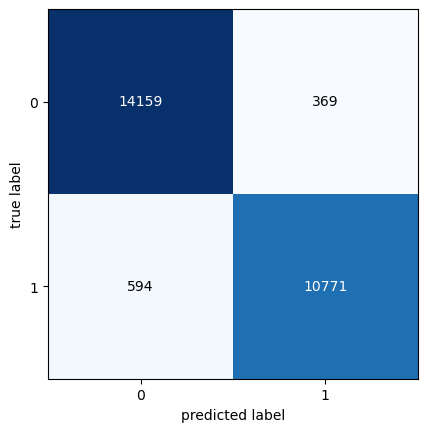

In [104]:
plot_confusion_matrix(conf_mat=matriz_confusao)

In [105]:
import joblib

In [106]:
joblib.dump(stacking_cv_classifier, 'modelo_treinado.pkl')

['modelo_treinado.pkl']

In [107]:
modelo_carregado = joblib.load('modelo_treinado.pkl')

In [108]:
X_teste.iloc[2]

Age                                     20
Flight Distance                        192
Inflight wifi service                    2
Departure/Arrival time convenient        0
Ease of Online booking                   2
Gate location                            4
Food and drink                           2
Online boarding                          2
Seat comfort                             2
Inflight entertainment                   2
On-board service                         4
Leg room service                         1
Baggage handling                         3
Checkin service                          2
Inflight service                         2
Cleanliness                              2
Departure Delay in Minutes               0
Arrival Delay in Minutes               0.0
Gender_Female                        False
Gender_Male                           True
Customer Type_Loyal Customer         False
Customer Type_disloyal Customer       True
Type of Travel_Business travel        True
Type of Tra

In [109]:
previsao = modelo_carregado.predict([X_teste.iloc[2]])

/home/rafael/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but ExtraTreesClassifier was fitted with feature names
  warnings.warn(
/home/rafael/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [110]:
previsao

array([0])